<a href="https://colab.research.google.com/github/theovincent/CPDE/blob/make_ipynb_working/TEP_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup (for colab only)

In [1]:
! git clone https://github.com/theovincent/CPDE.git -b make_ipynb_working

Cloning into 'CPDE'...
remote: Enumerating objects: 350, done.
remote: Counting objects: 100% (350/350), done.
remote: Compressing objects: 100% (275/275), done.
remote: Total 350 (delta 156), reused 232 (delta 71), pack-reused 0
Receiving objects: 100% (350/350), 6.61 MiB | 13.01 MiB/s, done.
Resolving deltas: 100% (156/156), done.


In [1]:
import os 

os.chdir("/content/CPDE")

! pip install -r requirements.txt

In [ ]:
! git pull

## Imports

In [17]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import ruptures as rpt
from SKAB_data.evaluating import evaluating_change_point

%load_ext autoreload
%autoreload 2

from ensemble_methods.aggregations import SCALING_AGGREGATION

SINGLE_COSTS = (
    {'name': 'ar_1', 'cost':'ar', 'params':{'order':1}},
    {'name': 'mahalanobis', 'cost':'mahalanobis', 'params':{}},
    {'name': 'l1', 'cost':'l1', 'params':{}},
    {'name': 'l2', 'cost':'l2', 'params':{}},
    {'name': 'rbf', 'cost': 'rbf', 'params': {}}
)
LIST_COSTS = [dict_cost["cost"] for dict_cost in SINGLE_COSTS]
PARAMS = {"ar": {'order':1}}

DESIRED_ORDER = ["Standart", "LowFP", "LowFN"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [18]:
from glob import glob

from sklearn.preprocessing import StandardScaler

# Get the data
files = sorted(glob('TEP_data/*_te.dat'))

columns=[]
for i in range(1, 42):
    columns.append("XMEAS({})".format(i))
for i in range(1, 12):
    columns.append("XMV({})".format(i))

# We do not use the first file because it does not contain a defect
test = {}
for i, j in enumerate(files[1:], start=1):
    test[i] = pd.read_table(j, sep="\s+", names=columns)

# Standardise
for idx_data in test:
    stsc = StandardScaler()
    test[idx_data] = pd.DataFrame(stsc.fit_transform(test[idx_data]), columns=test[idx_data].columns, index=test[idx_data].index)


# Get the labels
INDEX = pd.to_datetime(
        [datetime(2020,1,1)+timedelta(minutes=m) for m in test[1].index*3]
    )
true_cp = pd.Series(data=0, index=INDEX)
# Out of the 48 hours of monitoring, the faults were introduced 8 hours after the beginning
true_cp.iloc[160] = 1
true_cp = [true_cp]*len(test)

## Visualize a signal

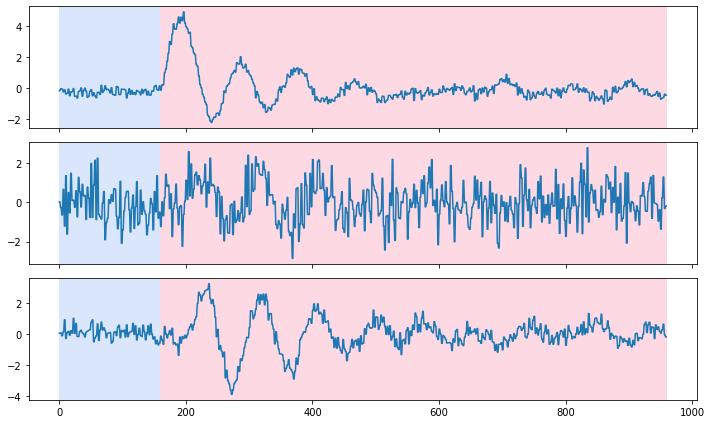

In [19]:
_ = rpt.display(test[1].values[:, 30: 33], [160, 960])

## Window search

In [20]:
def window_search(cost, params, **kwargs):
    predicted_cp = []
    for idx_data in test:
        algo = rpt.Window(model=cost, 
                          params=params, 
                          width=20,
                          jump=1)
        algo.fit(np.array(test[idx_data]))
        my_bkps = algo.predict(n_bkps=1)
        
        single_predicted_cp = pd.Series(data=0, index=true_cp[0].index)
        single_predicted_cp[single_predicted_cp.index[my_bkps[:-1]]] = 1
        predicted_cp.append(single_predicted_cp)

    nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='288 min')
    return nab

table_costs_window = {}
for cost in tqdm(SINGLE_COSTS):
    table_costs_window[cost["name"]] = window_search(**cost)

pd.DataFrame(table_costs_window).T[DESIRED_ORDER]

  0%|          | 0/5 [00:00<?, ?it/s]

,Standart,LowFP,LowFN
ar_1,21.27,21.02,22.12
mahalanobis,27.79,27.00,28.05
l1,20.63,19.85,21.69
l2,22.09,21.68,22.66
rbf,28.96,28.05,32.00


In [21]:
def window_search_ensemble_bound():
    predicted_cp = []
    for idx_data in tqdm(test):
        best_nab_sum = - float("inf")
        best_single_predicted_cp = pd.Series(data=0, index=true_cp[0].index)

        for model in SINGLE_COSTS:
            algo = rpt.Window(model=model["cost"], 
                            params=model["params"], 
                            width=20,
                            jump=1)
            algo.fit(np.array(test[idx_data]))
            my_bkps = algo.predict(n_bkps=1)
            
            single_predicted_cp = pd.Series(data=0, index=true_cp[0].index)
            single_predicted_cp[single_predicted_cp.index[my_bkps[:-1]]] = 1
            
            nab_model = evaluating_change_point([true_cp[0]], [single_predicted_cp], metric='nab', numenta_time='288 min')
            
            if sum(list(nab_model.values())) > best_nab_sum:
                best_nab_sum = sum(list(nab_model.values()))
                best_single_predicted_cp = single_predicted_cp
                
        predicted_cp.append(best_single_predicted_cp)

    nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='288 min')
    return nab

window_ensemble_bound = window_search_ensemble_bound()
pd.DataFrame(window_ensemble_bound, index=["Ensemble bound"])[DESIRED_ORDER]

  0%|          | 0/21 [00:00<?, ?it/s]

,Standart,LowFP,LowFN
Ensemble bound,40.13,39.62,41.04


In [22]:
from ensemble_methods.window_ensemble import WindowEnsemble

def window_search_ensemble(scale_aggregation):
    predicted_cp = []
    for idx_data in tqdm(test, leave=None, position=1):
        algo = WindowEnsemble(
            width=20,
            models=LIST_COSTS,
            params=PARAMS, 
            scale_aggregation=scale_aggregation,
            jump=1
        )
        single_predicted_cp = pd.Series(data=0, index=true_cp[0].index)
        
        algo.fit(np.array(test[idx_data]))
        my_bkps = algo.predict(n_bkps=1)

        single_predicted_cp[single_predicted_cp.index[my_bkps[:-1]]] = 1
        predicted_cp.append(single_predicted_cp)

    nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='288 min')
    return nab

In [23]:
table_ensemble_window = {}
for scale_aggregation_name, scale_aggregation in tqdm(SCALING_AGGREGATION.items(), position=0):
    table_ensemble_window[scale_aggregation_name] = window_search_ensemble(scale_aggregation)

pd.DataFrame(table_ensemble_window).T[DESIRED_ORDER]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

,Standart,LowFP,LowFN
Min_Raw,26.35,25.65,27.09
Min_MinMax,21.83,21.16,22.49
Min_Znorm,28.31,28.04,28.39
Min_MinAbs,28.96,28.05,32.00
Min_Rank,16.34,15.60,18.83
Sum_Raw,27.28,27.15,27.71
Sum_MinMax,27.28,27.15,27.71
Sum_Znorm,27.28,27.15,27.71
Sum_MinAbs,27.28,27.15,27.71
Sum_Rank,32.04,31.91,32.47


## Dynamic Programming

In [24]:
def dynp_search(cost, params, **kwargs):
    predicted_cp = []
    for idx_data in test:
        algo = rpt.Dynp(model=cost, 
                          params=params,
                          jump=1
                          )
        algo.fit(np.array(test[idx_data]))
        my_bkps = algo.predict(n_bkps=1)
        
        single_predicted_cp = pd.Series(data=0, index=true_cp[0].index)
        single_predicted_cp[single_predicted_cp.index[my_bkps[:-1]]] = 1
        predicted_cp.append(single_predicted_cp)

    nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='288 min')
    return nab

table_costs_dynp = {}
for cost in tqdm(SINGLE_COSTS):
    table_costs_dynp[cost["name"]] = dynp_search(**cost)

pd.DataFrame(table_costs_dynp).T[DESIRED_ORDER]

  0%|          | 0/5 [00:00<?, ?it/s]

,Standart,LowFP,LowFN
ar_1,30.15,28.89,32.80
mahalanobis,36.88,35.82,37.29
l1,32.53,31.98,32.80
l2,30.30,29.52,31.31
rbf,22.85,21.82,24.76


In [25]:
def dynp_search_ensemble_bound():
    predicted_cp = []
    for idx_data in tqdm(test):
        best_nab_sum = - float("inf")
        best_single_predicted_cp = pd.Series(data=0, index=true_cp[0].index)

        for model in SINGLE_COSTS:
            algo = rpt.Dynp(
                    model=model["cost"], 
                    params=model["params"],
                    jump=1
                )
            algo.fit(np.array(test[idx_data]))
            my_bkps = algo.predict(n_bkps=1)
            
            single_predicted_cp = pd.Series(data=0, index=true_cp[0].index)
            single_predicted_cp[single_predicted_cp.index[my_bkps[:-1]]] = 1
            
            nab_model = evaluating_change_point([true_cp[0]], [single_predicted_cp], metric='nab', numenta_time='288 min')
            
            if sum(list(nab_model.values())) > best_nab_sum:
                best_nab_sum = sum(list(nab_model.values()))
                best_single_predicted_cp = single_predicted_cp
                
        predicted_cp.append(best_single_predicted_cp)

    nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='288 min')
    return nab

dynp_ensemble_bound = dynp_search_ensemble_bound()
pd.DataFrame(dynp_ensemble_bound, index=["Ensemble bound"])[DESIRED_ORDER]

  0%|          | 0/21 [00:00<?, ?it/s]

,Standart,LowFP,LowFN
Ensemble bound,42.28,41.75,42.47


In [26]:
from ensemble_methods.dynamic_programming_ensemble import DynpEnsemble

def dynamique_programming_ensemble(scale_aggregation):
    predicted_cp = []
    for idx_data in tqdm(test, leave=False, position=1):
        algo = DynpEnsemble(
            models=LIST_COSTS,
            params=PARAMS, 
            scale_aggregation=scale_aggregation,
            jump=1
        )
        single_predicted_cp = pd.Series(data=0, index=true_cp[0].index)
        
        algo.fit(np.array(test[idx_data]))
        my_bkps = algo.predict(n_bkps=1)

        single_predicted_cp[single_predicted_cp.index[my_bkps[:-1]]] = 1
        predicted_cp.append(single_predicted_cp)

    nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='288 min')
    return nab

In [27]:
table_ensemble_dynp = {}
for scale_aggregation_name, scale_aggregation in tqdm(SCALING_AGGREGATION.items(), position=0):
    table_ensemble_dynp[scale_aggregation_name] = dynamique_programming_ensemble(scale_aggregation)

pd.DataFrame(table_ensemble_dynp).T[DESIRED_ORDER]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

,Standart,LowFP,LowFN
Min_Raw,22.85,21.82,24.76
Min_MinMax,32.60,31.58,34.43
Min_Znorm,27.70,26.67,29.58
Min_MinAbs,22.85,21.82,24.76
Min_Rank,41.79,40.74,42.15
Sum_Raw,30.20,28.95,32.83
Sum_MinMax,32.50,31.48,34.37
Sum_Znorm,32.50,31.48,34.37
Sum_MinAbs,30.20,28.95,32.83
Sum_Rank,29.99,29.19,31.10


## Binary Segmentation

In [28]:
def binseg_search(cost, params, **kwargs):
    predicted_cp = []
    for idx_data in test:
        algo = rpt.Binseg(model=cost, 
                          params=params,
                          jump=1)
        algo.fit(np.array(test[idx_data]))
        my_bkps = algo.predict(n_bkps=1)
        
        single_predicted_cp = pd.Series(data=0, index=true_cp[0].index)
        single_predicted_cp[single_predicted_cp.index[my_bkps[:-1]]] = 1
        predicted_cp.append(single_predicted_cp)

    nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='288 min')
    return nab

table_costs_dynp = {}
for cost in tqdm(SINGLE_COSTS):
    table_costs_dynp[cost["name"]] = binseg_search(**cost)

pd.DataFrame(table_costs_dynp).T[DESIRED_ORDER]

  0%|          | 0/5 [00:00<?, ?it/s]

,Standart,LowFP,LowFN
ar_1,30.15,28.89,32.80
mahalanobis,36.88,35.82,37.29
l1,32.53,31.98,32.80
l2,30.30,29.52,31.31
rbf,22.85,21.82,24.76


In [14]:
def binseg_search_ensemble_bound():
    predicted_cp = []
    for idx_data in tqdm(test):
        best_nab_sum = - float("inf")
        best_single_predicted_cp = pd.Series(data=0, index=true_cp[0].index)

        for model in SINGLE_COSTS:
            algo = rpt.Binseg(model=model["cost"], 
                          params=model["params"],
                          jump=1)
            algo.fit(np.array(test[idx_data]))
            my_bkps = algo.predict(n_bkps=1)
            
            single_predicted_cp = pd.Series(data=0, index=true_cp[0].index)
            single_predicted_cp[single_predicted_cp.index[my_bkps[:-1]]] = 1
            
            nab_model = evaluating_change_point([true_cp[0]], [single_predicted_cp], metric='nab', numenta_time='288 min')
            
            if sum(list(nab_model.values())) > best_nab_sum:
                best_nab_sum = sum(list(nab_model.values()))
                best_single_predicted_cp = single_predicted_cp
                
        predicted_cp.append(best_single_predicted_cp)

    nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='288 min')
    return nab

binseg_ensemble_bound = binseg_search_ensemble_bound()
pd.DataFrame(binseg_ensemble_bound, index=["Ensemble bound"])[DESIRED_ORDER]

  0%|          | 0/21 [00:00<?, ?it/s]

,Standart,LowFP,LowFN
Ensemble bound,42.54,42.27,42.65


In [15]:
from ensemble_methods.binary_segmentation_ensemble import BinsegEnsemble

def binary_segmentation_ensemble(scale_aggregation):
    predicted_cp = []
    for idx_data in tqdm(test, leave=False, position=1):
        algo = BinsegEnsemble(
            models=LIST_COSTS,
            params=PARAMS, 
            scale_aggregation=scale_aggregation,
            jump=1
        )
        single_predicted_cp = pd.Series(data=0, index=true_cp[0].index)
        
        algo.fit(np.array(test[idx_data]))
        my_bkps = algo.predict(n_bkps=1)

        single_predicted_cp[single_predicted_cp.index[my_bkps[:-1]]] = 1
        predicted_cp.append(single_predicted_cp)

    nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='288 min')
    return nab

In [16]:
table_ensemble_dynp = {}
for scale_aggregation_name, scale_aggregation in tqdm(SCALING_AGGREGATION.items(), position=0):
    table_ensemble_dynp[scale_aggregation_name] = binary_segmentation_ensemble(scale_aggregation)

pd.DataFrame(table_ensemble_dynp).T[DESIRED_ORDER]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

,Standart,LowFP,LowFN
Min_Raw,32.60,31.58,34.43
Min_MinMax,32.60,31.58,34.43
Min_Znorm,30.06,29.02,31.15
Min_MinAbs,4.50,4.24,4.59
Min_Rank,41.79,40.74,42.15
Sum_Raw,30.20,28.95,32.83
Sum_MinMax,32.14,31.08,34.13
Sum_Znorm,32.14,31.08,34.13
Sum_MinAbs,32.14,31.08,34.13
Sum_Rank,20.59,19.80,21.67
